# **Proyecto Generación de música automática**

![picture](https://www.smartpiano.com.au/wp-content/uploads/2017/11/Fotolia_83643105_Subscription_Monthly_M.jpg)

El presente proyecto se trata de la creación automática de pequeños fragmentos musicales usando diferentes párameteros como intervalos, acordes, ritmos, tempo, entre otros, a partir de obras para piano de compositores  principalmente del clasicismo y del romanticismo en formato MIDI que se encuentran disponibles en Kaggle en el siguiente enlace: https://www.kaggle.com/soumikrakshit/classical-music-midi

## **0. Objetivos**



*   Implementar un modelo que permita la generación de fragmentos musicales para piano a partir de ciertos parámetros introducidos por el usuario.
*   Utilizar una red neuronal LSTM como modelo de Deep Learning





## **1. Dataset**

Descargamos el dataset que se encuentra en Google Drive

In [1]:
!gdown 1L-4v6oKVdPqMsgNF84ns7xlMSY2-2Eyn

Downloading...
From: https://drive.google.com/uc?id=1L-4v6oKVdPqMsgNF84ns7xlMSY2-2Eyn
To: /content/Music_generation.zip
100% 2.45M/2.45M [00:00<00:00, 178MB/s]


Los audios en formato MIDI se encuentran comprimidos en zip y los incluimos en la carpeta 'music':

In [2]:
!mkdir music

In [ ]:
!unzip "/content/Music_generation.zip" -d 'music'

Tenemos en total 295 archivos MIDI:

In [4]:
import os
count = 0
for root_dir, cur_dir, files in os.walk('music'):
    count += len(files)
print('file count:', count)

file count: 295


Veámos la estructura de los datos en la carpeta 'music'

In [5]:
!apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 46 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 0s (130 kB/s)
Selecting previously unselected package tree.
(Reading database ... 122541 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...


In [ ]:
!tree music

# **2. Exploración y Preprocesamiento de los datos**

Para este proyecto vamos a ser uso extensivo de la librería music21, la cual permite analizar los archivos MIDI y extraer las notas (entendidas como frecuencias o alturas y sus duraciones) y acordes (notas que suenan simultáneamente) del archivo.

In [18]:
from music21 import *
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM,Dense,Input,Dropout
from tensorflow.keras.models import Sequential,Model,load_model
from sklearn.model_selection import train_test_split

Lectura y análisis de los archivos MIDI

In [22]:
def extract_notes(file):
  notes=[]
  pick=None
  #convertimos el archivo midi
  midi=converter.parse(file)
  #separamos los instrumentos del archivo
  instrmt=instrument.partitionByInstrument(midi)

  for part in instrmt.parts:
    #separamos los datos solamente para piano
    if 'Piano' in str(part):
      pick=part.recurse()

      #se itera sobre los elementos
      #Se verifica si el elemento es nota o acorde, en caso de este último se separa en notas

      for element in pick:
        if type(element)==note.Note:
          notes.append(str(element.pitch))
        elif type(element)==chord.Chord:
          notes.append('.'.join(str(n) for n in element.normalOrder))

  #retornamos una lista de las notas
  return notes

Por simplicidad vamos a utilizar solamente los archivos MIDI del compositor noruego Edvard Grieg:

In [23]:
file_path=["music/grieg"]
all_files=glob.glob(file_path[0]+'/*.mid',recursive=True)
#conformamos el corpus con los archivos MIDI preprocesados
corpus = np.array([extract_notes(i) for i in all_files], dtype=object)

Revisemos cuántas notes únicas se tienen y cuál es su distribución:

Unique Notes: 248
30 : 116
50 : 89
70 : 64
90 : 51
110 : 44
130 : 33
150 : 29
170 : 23
190 : 16


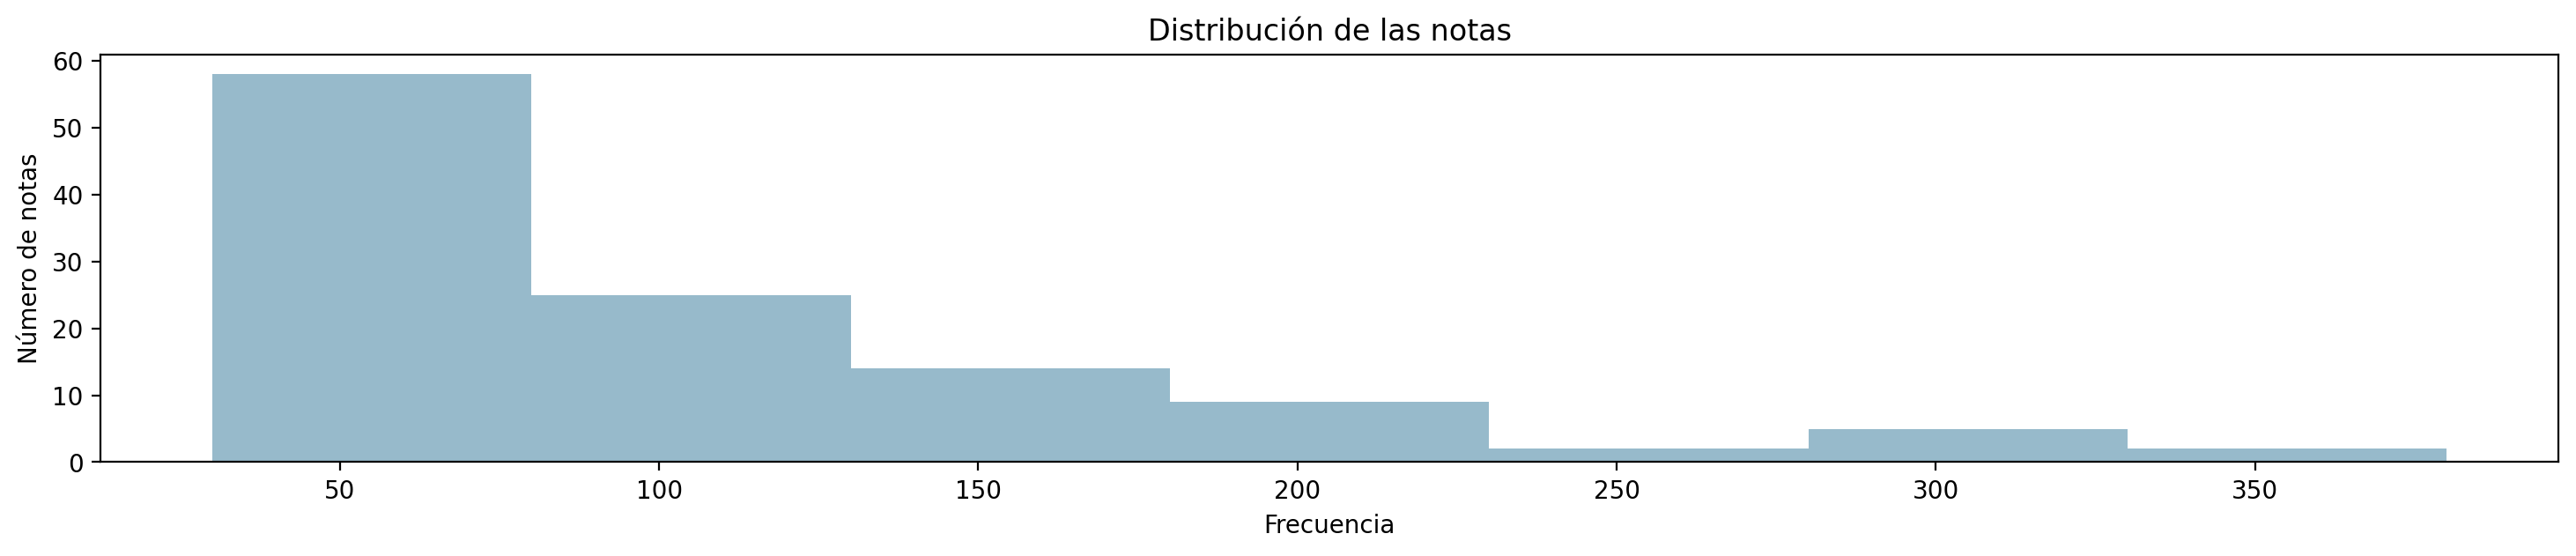

In [54]:
#notas únicas
notess = sum(corpus,[])
unique_notes = list(set(notess))
print("Unique Notes:",len(unique_notes))
#notas con su frecuencia
freq=dict(map(lambda x: (x,notess.count(x)),unique_notes))
recurrence = list(freq.values())
for i in range(30,200,20):
  print(i,":",len(list(filter(lambda x:x[1]>=i,freq.items()))))
#gráfica
plt.figure(figsize=(18,3))
bins = np.arange(30,max(recurrence), 50)
plt.hist(recurrence, bins=bins, color="#97BACB")
plt.title("Distribución de las notas")
plt.xlabel("Frecuencia")
plt.ylabel("Número de notas")
plt.show()


Seleccionamos un umbral para la frecuenca de las notas para remover sonidos de baja frecuencia y facilitar la generación de la música

In [45]:
umbral = 50
freq_notes=dict(filter(lambda x:x[1]>=umbral,freq.items()))
#creamos nuevas notas usando la frecuencia
new_notes=[[i for i in j if i in freq_notes] for j in corpus]

Creamos diccionarios con los índices de las notas como keys y notas como values y viceversa:

In [51]:
#diccionario con el índice de nota como key y la nota como value
ind2note=dict(enumerate(freq_notes))
#diccionario con la nota como key y el índice de nota como value
note2ind=dict(map(reversed,ind2note.items()))
print(ind2note.items())
print(len(note2ind))

dict_items([(0, 'G2'), (1, 'E-5'), (2, '4.7'), (3, '2.5'), (4, 'C#3'), (5, '2.6'), (6, '2.7'), (7, 'C#4'), (8, '11.2'), (9, 'B3'), (10, '9'), (11, '3.6'), (12, 'G5'), (13, 'D5'), (14, '6.9'), (15, '7.9'), (16, 'F5'), (17, 'E6'), (18, 'D3'), (19, 'F#3'), (20, 'B2'), (21, 'C#5'), (22, '9.1.4'), (23, '1.6'), (24, 'D6'), (25, 'A5'), (26, 'C#6'), (27, '1.4'), (28, '2'), (29, 'F#5'), (30, '6.10.1'), (31, '6.11'), (32, 'C6'), (33, '0.4'), (34, '7.11.2'), (35, 'E-4'), (36, 'G3'), (37, '8.11'), (38, '0.6'), (39, 'F#2'), (40, 'F#4'), (41, '2.6.9'), (42, 'C4'), (43, 'C3'), (44, '4.9'), (45, 'A2'), (46, 'G#4'), (47, '7.10'), (48, '10.1'), (49, '6.10'), (50, '11.3'), (51, 'G4'), (52, '7.11'), (53, 'F4'), (54, '11.4'), (55, 'A4'), (56, 'A3'), (57, 'B-4'), (58, 'B-3'), (59, 'D2'), (60, '0.2'), (61, '0'), (62, '4.7.11'), (63, 'G#5'), (64, '10.0'), (65, 'E2'), (66, 'B1'), (67, 'B4'), (68, 'B5'), (69, '10.3'), (70, 'E3'), (71, '9.10'), (72, 'B-5'), (73, 'G#3'), (74, '7.0'), (75, 'F6'), (76, 'E4'), (77, 

# **Datos de entrada y salida para el modelo**

In [52]:
#timestep
timesteps=50
#store values of input and output
x=[] ; y=[]
for i in new_notes:
 for j in range(0,len(i)-timesteps):
  #input will be the current index + timestep
  #output will be the next index after timestep
  inp=i[j:j+timesteps] ; out=i[j+timesteps]
  #append the index value of respective notes
  x.append(list(map(lambda x:note2ind[x],inp)))
  y.append(note2ind[out])
x_new=np.array(x)
y_new=np.array(y)

In [55]:
print(x_new.shape, y_new.shape)

(10922, 50) (10922,)
